In [2]:
!pip install tensorflow numpy pandas matplotlib scikit-learn statsmodels

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras import layers, Model

In [4]:
# Generate synthetic multivariate dataset
np.random.seed(42)
time = np.arange(0, 2000)
signal = 0.05 * time + 10 * np.sin(time / 20) + np.random.normal(0, 2, size=len(time))

df = pd.DataFrame({
    'timestamp': time,
    'demand': signal,
    'temperature': 25 + 5*np.sin(time/50),
    'price_index': 100 + 0.03 * time + np.random.normal(0, 0.5, size=len(time))
})

df.head()

,timestamp,demand,temperature,price_index
0,0,0.993428,25.000000,99.662411
1,1,0.273263,25.099993,99.957741
2,2,2.393711,25.199947,99.663790
3,3,4.690441,25.299820,99.936019
4,4,1.718387,25.399573,99.173193


In [5]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['demand','temperature','price_index']])

WINDOW = 50
HORIZON = 1  # forecast 1-step ahead

def create_windows(data, window, horizon):
    X, y = [], []
    for i in range(len(data) - window - horizon):
        X.append(data[i:i+window])
        y.append(data[i+window:i+window+horizon, 0])  # demand only
    return np.array(X), np.array(y)

X, y = create_windows(scaled, WINDOW, HORIZON)
X.shape, y.shape

((1949, 50, 3), (1949, 1))

In [6]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [7]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs, return_attention_scores=False)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)

In [8]:
def build_model(input_shape, embed_dim=32, ff_dim=64, num_heads=4):
    inputs = layers.Input(shape=input_shape)
    # Project the input features to embed_dim
    x = layers.Dense(embed_dim)(inputs)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_model((WINDOW, 3))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 50, 32)         │        21,120 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,281 (83.13 KB)

 Trainable params: 21,281 (83.13 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.9875 - val_loss: 0.0983
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0146 - val_loss: 0.0213
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0064 - val_loss: 0.0157
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0058 - val_loss: 0.0245
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0059 - val_loss: 0.0194
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0057 - val_loss: 0.0204
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0057 - val_loss: 0.0319
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0067 - val_loss: 0.0176
Epoch 9/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0056 - val_loss: 0.0231
Epoch 10/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0056 - val_loss: 0.0182
Epoch 11/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0052 - val_loss: 0.0270
Epoch 12/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0

In [10]:
pred = model.predict(X_test)

# The scaler was fit on 3 features ('demand', 'temperature', 'price_index').
# To inverse transform 'demand' (which is the first feature in the original scaled data),
# we need to provide an array with 3 columns to scaler.inverse_transform.
# The values for the other two features (temperature, price_index) don't matter
# in the temporary array for inverse_transform, as we are only interested in
# the inverse transformed 'demand' column. We'll use zeros as placeholders.

# Inverse scale y_test (true demand values)
# Create a temporary array of shape (num_samples, 3)
temp_array_for_y_test = np.hstack([y_test, np.zeros_like(y_test), np.zeros_like(y_test)])
test_rescaled = scaler.inverse_transform(temp_array_for_y_test)[:, 0]

# Inverse scale pred (predicted demand values)
# Create a temporary array of shape (num_samples, 3)
temp_array_for_pred = np.hstack([pred, np.zeros_like(pred), np.zeros_like(pred)])
pred_rescaled = scaler.inverse_transform(temp_array_for_pred)[:, 0]

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [11]:
rmse = sqrt(mean_squared_error(test_rescaled, pred_rescaled))
print("RMSE:", rmse)

RMSE: 26.65828240100163


In [12]:
naive_forecast = test_rescaled[:-1]
mase = np.mean(np.abs(test_rescaled[1:] - pred_rescaled[1:])) / np.mean(np.abs(test_rescaled[1:] - naive_forecast))
print("MASE:", mase)

MASE: 11.400920623427812


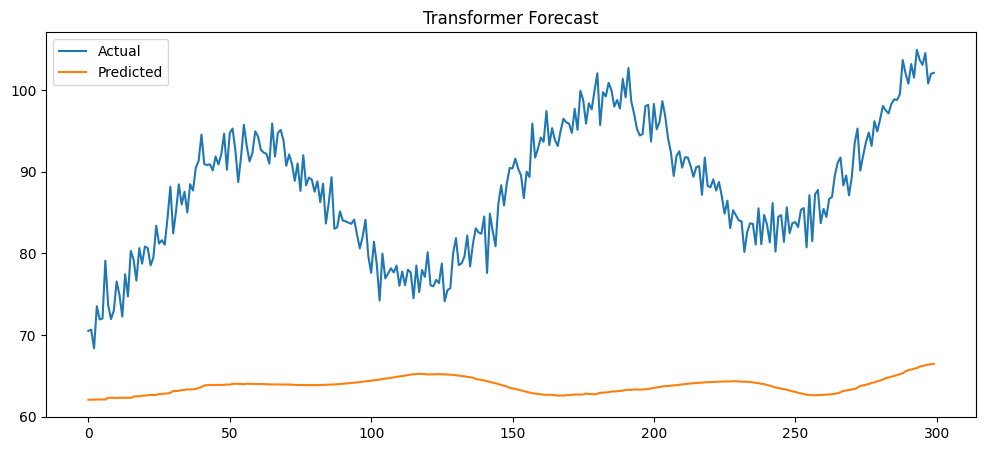

In [13]:
plt.figure(figsize=(12,5))
plt.plot(test_rescaled[:300], label="Actual")
plt.plot(pred_rescaled[:300], label="Predicted")
plt.legend()
plt.title("Transformer Forecast")
plt.show()

In [14]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df['demand'], order=(5,1,2)).fit()
arima_pred = arima_model.forecast(steps=len(y_test))

rmse_arima = sqrt(mean_squared_error(test_rescaled[:len(arima_pred)], arima_pred))
print("ARIMA RMSE:", rmse_arima)

ARIMA RMSE: 15.041313370551856


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
